In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import os

from sklearn.utils import resample
import numpy as np

import glob


In [4]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)




### Preprocessing of nickel price (LME), nickel global production (USGS Annual Reports), China GDP per capita and growth (World Bank) 

- Nickel global production link: https://www.usgs.gov/centers/nmic/nickel-statistics-and-information
- GDP China link: https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=CN

In [5]:

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']

LME_futures = LME_futures.iloc[:, 1:]
#LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()

LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()

inventory = LME_futures.iloc[:, 1]
inventory = inventory.astype(float)
inventory = inventory.resample('B').mean()

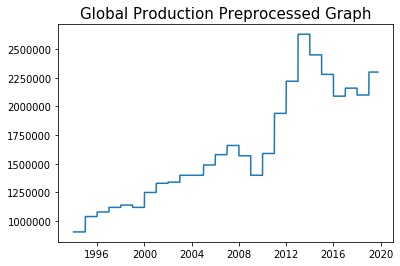

In [6]:
global_production = pd.read_excel('forecasting_raw_data/nickel_features/nickel_extracted.xlsx')
date_index = [datetime.datetime(year, 1, 1) for year in range(1994, 2021)]
series = list(global_production.iloc[:, 1])
series.append(np.nan)

global_production = pd.DataFrame({'global_prod': series})
global_production.index = date_index


global_production = global_production.resample('B').ffill()
upsampled_prod = global_production.interpolate(method='linear')

upsampled_prod = upsampled_prod.dropna()
upsampled_prod = upsampled_prod.loc[:LME.index[-1], :]

LME = LME[upsampled_prod.index]
plt.plot(upsampled_prod)
plt.title('Global Production Preprocessed Graph', fontsize=15)
plt.show()

In [109]:
china_gdp

Indicator Name,GDP per capita (current US$),GDP per capita growth (annual %),GDP per capita growth (annual %)
1961-12-29,NaN,NaN,NaN
1962-01-01,75.805838,-26.527644,-26.527644
1962-01-02,75.805838,-26.527644,-26.527644
1962-01-03,75.805838,-26.527644,-26.527644
1962-01-04,75.805838,-26.527644,-26.527644
1962-01-05,75.805838,-26.527644,-26.527644
1962-01-08,75.805838,-26.527644,-26.527644
1962-01-09,75.805838,-26.527644,-26.527644
1962-01-10,75.805838,-26.527644,-26.527644
1962-01-11,75.805838,-26.527644,-26.527644


In [97]:
files = glob.glob('forecasting_raw_data/china_data/*' + ".csv")


china = pd.DataFrame()
for file in files:
    print(file)
    df = pd.read_csv(file, header=2)
    china_row = df[df['Country Name'] == 'China' ]
    
    
    
    china = df_main.append(china_row)
    #print(china_row)
    
china.index = china['Indicator Name']
china = china.loc[:, '1961':]
china = china.T
china = china.dropna(how='all')


#china.to_csv('china_gdp_consumption_summary.csv')

new_index = []
for item in china.index:
    new_index.append(datetime.datetime(int(item), 12, 31))
    
china.index = new_index

forecasting_raw_data/china_data\API_NE.CON.TOTL.CD_DS2_en_csv_v2_427575.csv
forecasting_raw_data/china_data\API_NE.CON.TOTL.ZS_DS2_en_csv_v2_427582.csv
forecasting_raw_data/china_data\API_NY.GDP.PCAP.CD_DS2_en_csv_v2_422141.csv
forecasting_raw_data/china_data\API_NY.GDP.PCAP.KD.ZG_DS2_en_csv_v2_422038.csv


In [98]:
china_consump = china[['Final consumption expenditure (current US$)', 'Final consumption expenditure (% of GDP)']]

china_gdp = china[['GDP per capita (current US$)', 'GDP per capita growth (annual %)']]

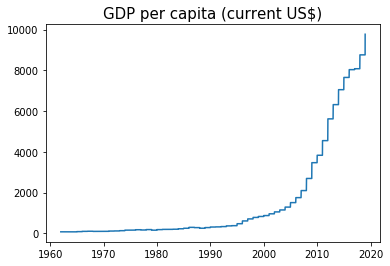

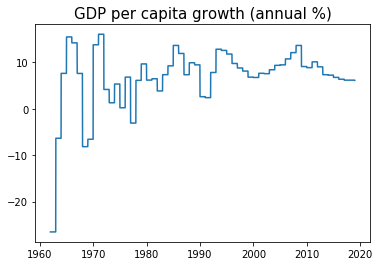

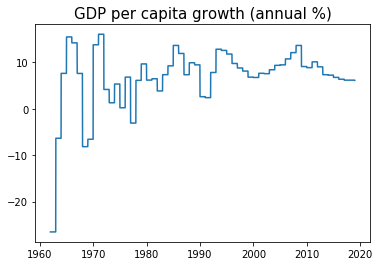

Indicator Name,GDP per capita (current US$),GDP per capita growth (annual %),GDP per capita growth (annual %)
1961-12-29,NaN,NaN,NaN
1962-01-01,75.805838,-26.527644,-26.527644
1962-01-02,75.805838,-26.527644,-26.527644
1962-01-03,75.805838,-26.527644,-26.527644
1962-01-04,75.805838,-26.527644,-26.527644
1962-01-05,75.805838,-26.527644,-26.527644
1962-01-08,75.805838,-26.527644,-26.527644
1962-01-09,75.805838,-26.527644,-26.527644
1962-01-10,75.805838,-26.527644,-26.527644
1962-01-11,75.805838,-26.527644,-26.527644


In [103]:


china_gdp = china_gdp.resample('B').ffill()
upsampled_china = china_gdp.interpolate(method='linear')


for i in range(len(upsampled_china.columns)):

    plt.plot(upsampled_china.iloc[:, i])
    plt.title(str(upsampled_china.columns[i]), fontsize=15)
    plt.show()
    
upsampled_china

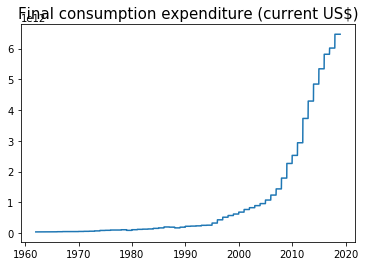

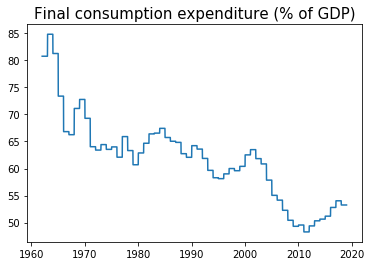

Indicator Name,Final consumption expenditure (current US$),Final consumption expenditure (% of GDP)
1961-12-29,NaN,NaN
1962-01-01,4.042164e+10,80.751440
1962-01-02,4.042164e+10,80.751440
1962-01-03,4.042164e+10,80.751440
1962-01-04,4.042164e+10,80.751440
1962-01-05,4.042164e+10,80.751440
1962-01-08,4.042164e+10,80.751440
1962-01-09,4.042164e+10,80.751440
1962-01-10,4.042164e+10,80.751440
1962-01-11,4.042164e+10,80.751440


In [106]:
china_consump = china_consump.resample('B').ffill()
upsampled_china = china_consump.interpolate(method='linear')


for i in range(len(upsampled_china.columns)):

    plt.plot(upsampled_china.iloc[:, i])
    plt.title(str(upsampled_china.columns[i]), fontsize=15)
    plt.show()
    
upsampled_china